# Lista 1

Nome: Gabriel Carvalho Benedito

Matrícula: 2013100874

## Imports

In [116]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import image, colors
from matplotlib.ticker import PercentFormatter

# inline plots
%matplotlib inline

# increase DPI
mpl.rcParams['figure.dpi'] = 150

## Funções personalizadas

In [117]:
# NOTE: all custom function assumes normalized images on range [0, 1]

# plots an grayscale image
def plot_gray_img(img, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# plots an frequency and density histogram
def plot_hist(img, n_bins=30):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Histograma')
    plt.subplots_adjust(wspace=0.39)

    # vetorize image (transform to 1D-vector)
    vect_img = np.reshape(img, (-1))

    # stats
    img_mean = np.mean(vect_img)
    img_median = np.median(vect_img)
    mean_label = 'Média = {:.2f}'.format(img_mean)
    median_label = 'Mediana = {:.2f}'.format(img_median)

    # frequencies
    axs[0].hist(vect_img, bins=n_bins)
    axs[0].axvline(img_mean, c='g', label=mean_label)
    axs[0].axvline(img_median, c='r', label=median_label)
    axs[0].legend(fontsize='xx-small')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylabel('Número de pixels')
    axs[0].set_xlabel('Intensidade [0, 1]')

    # density
    weights = np.ones_like(vect_img) / vect_img.size
    axs[1].hist(vect_img, bins=n_bins, weights=weights)
    axs[1].axvline(img_mean, c='g', label=mean_label)
    axs[1].axvline(img_median, c='r', label=median_label)
    axs[1].legend(fontsize='xx-small')
    axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axs[1].set_xlim(0, 1)
    axs[1].set_ylabel('Densidade')
    axs[1].set_xlabel('Intensidade [0, 1]')


## Exercício 1

In [118]:
# open image
img = image.imread('./img/ex_1.jpg')

# transforms
# normalize values
img = img / 255

### Imagem original

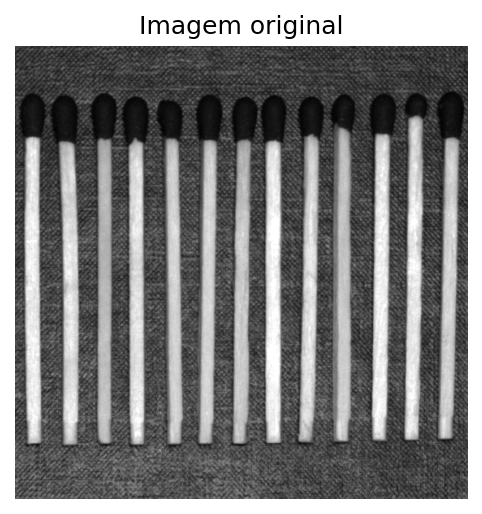

In [121]:
plot_gray_img(img, 'Imagem original')

### Histograma

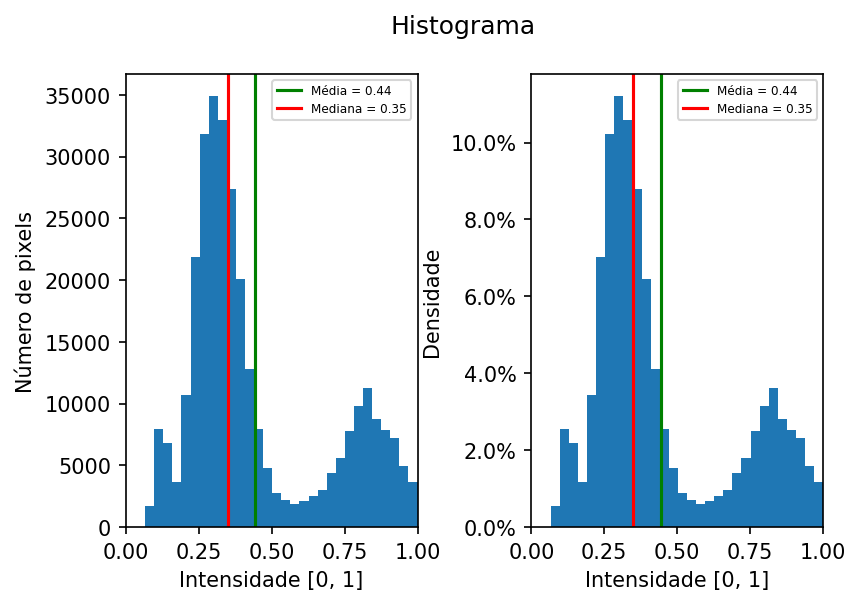

In [122]:
plot_hist(img)

In [161]:
# sigmoif intensity transform
sig = lambda x, r: 1 / (1 + np.exp(-r * np.tan(np.pi * (x - 1/2))))
sig_func = np.vectorize(sig)

4.791929343058691e-205
1.0


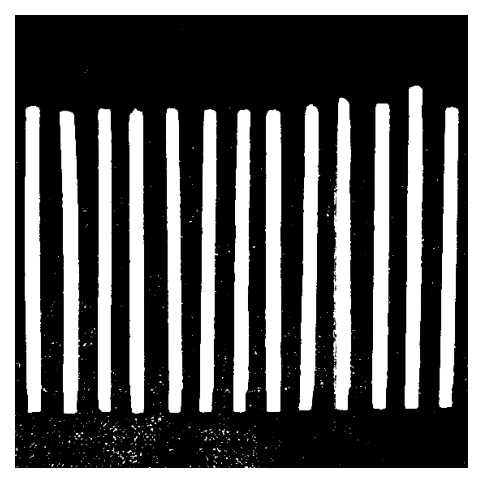

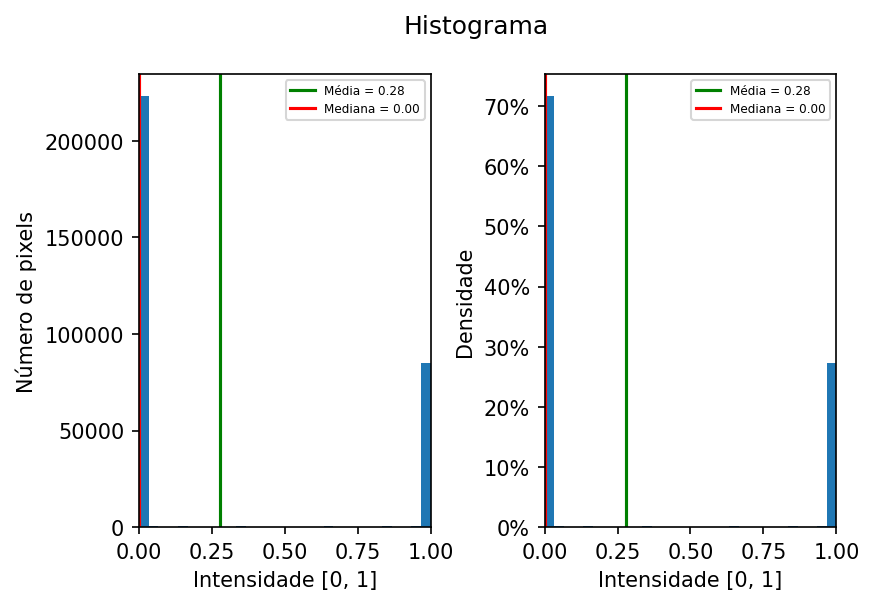

In [162]:
img_int_t = sig_func(img, 100)
print(np.min(img_int_t))
print(np.max(img_int_t))
plot_gray_img(img_int_t)
plot_hist(img_int_t)